In [1]:
from torch import nn
import torch
import pandas as pd
import numpy as np
import os
from torchvision.io import read_image
from torchvision import datasets
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
import transforms3d as tf
from vit_pytorch import ViT

torch.cuda.is_available()

KeyboardInterrupt: 

In [2]:
def createPickle():
    stereo_left_df = pd.read_csv("indoor_forward_9_snapdragon_with_gt/left_images.txt", delimiter=' ', skiprows=1, names=["id", "timestamp", "image_name"], index_col=False) 
    labels_df = pd.read_csv("indoor_forward_9_snapdragon_with_gt/groundtruth.txt", delimiter=' ', skiprows=1, names=["timestamp", "tx", "ty", "tz", "qx", "qy", "qz", "qw", "img_start_idx"])
    for i in range(len(labels_df)):
        minid = abs(stereo_left_df["timestamp"]-labels_df.iloc[i]["timestamp"]).idxmin()
        labels_df["img_start_idx"][i] = minid
    labels_df.to_pickle("./stereo_indexed_labels.pickle")
createPickle()

In [2]:
class StereoDataset(Dataset):
    def __init__(self, data_dir, label_delta_len):
        self.stereo_data = self.preprocess_images()

        self.labels_df = pd.read_csv("indoor_forward_9_snapdragon_with_gt/groundtruth.txt", delimiter=' ', skiprows=1, names=["timestamp", "tx", "ty", "tz", "qx", "qy", "qz", "qw", "img_start_idx"])
        labels_df_nostamp = self.labels_df.loc[:, self.labels_df.columns != 'timestamp']
        labels_df_nostamp = labels_df_nostamp.loc[:, labels_df_nostamp.columns != 'events_start_idx']
        self.labels = torch.tensor(labels_df_nostamp.to_numpy(), dtype=torch.float32)

        self.delta = label_delta_len

    def __len__(self):
        return self.labels.shape[0] - self.delta

    def set_label_delta(self, delta):
        self.delta = delta

    def __getitem__(self, idx):
        return self.stereo_data[idx]


    def preprocess_images(self):
        data_dir = "indoor_forward_9_snapdragon_with_gt/"
        img_annot_cols=["stamp","name","none"]
        left_images = pd.read_csv(data_dir + "left_images.txt", delimiter=' ', skiprows=1, names=img_annot_cols)
        right_images = pd.read_csv(data_dir + "right_images.txt", delimiter=' ', skiprows=1, names=img_annot_cols)
        images = []

        print("Preprocessing images")
        for idx, i in enumerate(zip(left_images['name'], right_images['name'])):
            if idx % 100 == 0:
                print(idx)
            left_image = Image.open(data_dir + i[0])
            right_image = Image.open(data_dir +  i[1])
            left_image = left_image.resize((160,120))
            right_image = right_image.resize((160,120))
            concat = Image.new('L', (left_image.width + right_image.width, left_image.height))
            concat.paste(left_image, (0,0))
            concat.paste(right_image, (left_image.width,0))
            images.append(concat)

        tensors = []
        convert_tensor = transforms.ToTensor()
        print("Creaing tensors")
        for i, v in enumerate(images):
            if i % 100 == 0:
                print(i)
            tensors.append(convert_tensor(v))

        print("Stacking tensors")
        output = []
        for i in range(2, len(tensors)):
            if i % 100 == 0:
                print(i)            
            output.append(torch.stack(tensors[i-2:i+1]))

        return output

data_dir = "indoor_forward_9_davis_with_gt"
vio_dataset = StereoDataset(data_dir, 1)

Preprocessing images
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
Creaing tensors
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
Stacking tensors
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000


2066

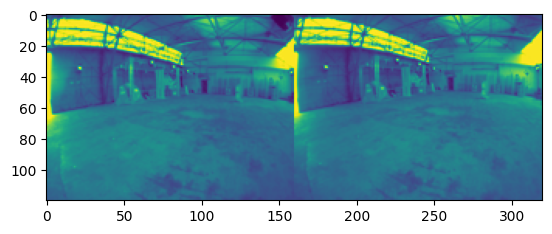

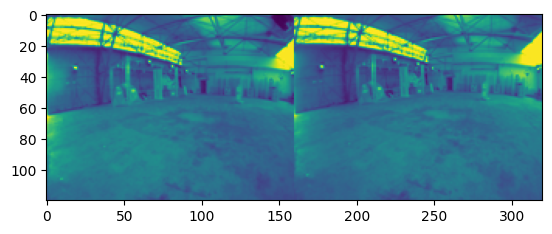

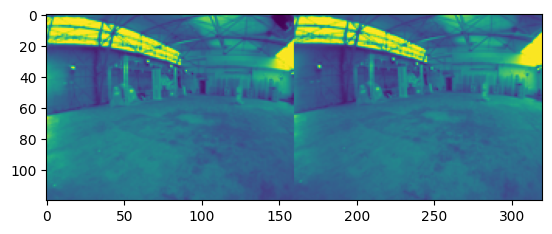

In [4]:
events = vio_dataset.__getitem__(1000).squeeze(0)

for i in range(3):
    plt.figure(i)
    plt.imshow(events[i][0])
events.shape
len(vio_dataset.stereo_data)

In [5]:
model = ViT(
    image_size = 400,
    patch_size = 50,
    num_classes = 7,
    dim = 32,
    depth = 6,
    heads = 16,
    mlp_dim = 64,
    dropout = 0.1,
    emb_dropout = 0.,
    channels=1
)

#img = vio_dataset.__getitem__(1002).unsqueeze(0) # batch 1

#preds = model(img) # (1, 7)
#preds

In [6]:
model = model.to(device)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[20,40], gamma=.25)
dataloader = torch.utils.data.DataLoader(vio_dataset, batch_size=32, shuffle=True, num_workers=8)
next(iter(dataloader))[0].shape

In [ ]:
# https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html training loop from here

torch.cuda.empty_cache()

num_epochs = 50
for epoch in range(num_epochs):
    print(f'Epoch {epoch}/{num_epochs - 1}')
    print('-' * 10)

    for phase in ['train']:
        if phase == 'train':
            model.train()  # Set model to training mode
        else:
            model.eval()   # Set model to evaluate mode

        running_loss = 0.0

        # Iterate over data.
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(vio_dataset)

        print(f'{phase} Loss: {epoch_loss:.4f}')
        scheduler.step()

In [ ]:
model.eval()
path = []
ground = []
x = np.zeros((3,1))
gtx = np.zeros((3,1))
for i in range(int(len(vio_dataset)/vio_dataset.delta)):
    data_point = vio_dataset.__getitem__(i*vio_dataset.delta)
    delta_label = data_point[1].numpy().reshape(7,1)[:3]
    gtx += delta_label
    ground.append(gtx.copy())
    inputs = data_point[0].unsqueeze(0).to(device)
    outputs = model(inputs)
    dx = outputs.cpu().detach().numpy().T[:3]
    x += dx
    path.append(x.copy())
path = np.array(path).reshape(-1,3)
ground = np.array(ground).reshape(-1,3)
fig = plt.figure(dpi=200)
ax = plt.axes(projection='3d')
ax.plot3D(path[:,0],path[:,1],path[:,2])
ax.plot3D(ground[:,0],ground[:,1],ground[:,2])

plt.figure(2, dpi=150)
plt.plot(path[:,0],path[:,1])
plt.plot(ground[:,0],ground[:,1])
plt.legend(["pred","ground"])